### Import Dependencies

In [1]:
## Get dependencies ##

import numpy as np
import string
import math
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
sys.path.append('..')
from GIR import *
import scipy as sp
import pickle
import time
import scipy as sp
from scipy import signal
from scipy.io.idl import readsav
import os
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import glob
import requests
import ftplib
import io
import cmocean
from bs4 import BeautifulSoup
import urllib.request
from io import StringIO, BytesIO
from zipfile import ZipFile
import tqdm
import seaborn as sn
import re

## get SSP emissions
from tools.RCMIP import *

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}
    
## Matplotlib rcparams setup:

matplotlib.rcParams['font.family']='Helvetica'
matplotlib.rcParams['font.size']=11
# matplotlib.rcParams['font.weight']=400

matplotlib.rcParams['image.cmap']='cmo.ice'

matplotlib.rcParams['axes.prop_cycle']=matplotlib.cycler('color',['011936','FF7D00','225560','BFACAA','D72638','788C9B','A33F00','7CAAB0','685655','EB767C'])
matplotlib.rcParams['axes.formatter.limits']=-3,3
# matplotlib.rcParams['axes.labelweight']=300

matplotlib.rcParams['legend.frameon']=False

matplotlib.rcParams['boxplot.whiskers']=(5,95)
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.medianprops.color']='black'

matplotlib.rcParams['errorbar.capsize']=5

matplotlib.rcParams['hist.bins']='auto'

plt.rcParams['pdf.fonttype'] = 42

%matplotlib inline

%load_ext line_profiler
%load_ext memory_profiler

/home/leachl/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
../tools/RCMIP.py:61: PerformanceWarning: indexing past lexsort depth may impact performance.
  GIR_to_RCMIP_map.loc[RCMIP_to_GIR_map_concs.values(),'RCMIP_concs_unit'] = RCMIP_concs.loc[('World','ssp245')].reindex(RCMIP_to_GIR_map_concs.keys()).loc[:,'Unit'].values#.loc[('World','ssp245',RCMIP_to_GIR_map_concs.keys()),'Unit'].values


In [2]:
default_params = pd.read_csv('../Parameter_Sets/Complete_gas_cycle_params.csv',skiprows=1,index_col=0)
forcing_namelist = list(default_params.columns)

param_categories = {}
param_categories['other_wmghgs'] = ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8','carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methyl_bromide', 'methyl_chloride', 'nf3', 'sf6', 'so2f2', 'halon1202']
param_categories['carbon_dioxide'] = ['carbon_dioxide']
param_categories['methane'] = ['methane']
param_categories['nitrous_oxide'] = ['nitrous_oxide']
param_categories['trop_o3'] = [x for x in forcing_namelist if '|trop_o3' in x]
param_categories['strat_o3'] = [x for x in forcing_namelist if '|strat_o3' in x]
param_categories['strat_h2o'] = [x for x in forcing_namelist if '|strat_h2o' in x]
param_categories['ari'] = ['so2', 'nox', 'co', 'nmvoc', 'bc', 'nh3','oc','nox_avi']
param_categories['aci'] = ['so2|aci','oc|aci','bc|aci']
param_categories['aer'] = param_categories['aci'] + param_categories['ari']
param_categories['bc_on_snow'] = ['bc|bc_on_snow']
param_categories['contrails'] = ['nox_avi|contrails']

## Import datasets

In [3]:
# MAGICC7.1.0.beta RCMIP runs
magicc_scm = pd.read_csv('/home/leachl/Documents/Datasets/RCMIP/rcmip/data/results/phase-1/magicc7/rcmip_phase-1_magicc7.1.0.beta_v1-0-0.csv').set_index(['Region','Scenario','Variable'])
magicc_scm.iloc[:,3:] = magicc_scm.iloc[:,3:].apply(pd.to_numeric)
magicc_scm.columns = list(magicc_scm.columns)[:3] + [int(x) for x in list(magicc_scm.columns)[3:]]

In [4]:
## RCMIP SSP emissions:
scenarios = ['ssp'+x for x in ['119','245','585','370']]#['ssp'+x for x in ['119','126','245','370','370-lowNTCF-aerchemmip','370-lowNTCF-gidden','434','460','534-over','585']]
ssp_emms = pd.concat([RCMIP_to_GIR_input_emms(x) for x in scenarios],keys=['esm-'+x+'-allGHG' for x in scenarios],axis=1).interpolate()
ssp_emms = ssp_emms.loc[1750:2150] - ssp_emms.loc[1750]
ssp_forc = pd.concat([get_RCMIP_forc(x) for x in scenarios],keys=['esm-'+x+'-allGHG' for x in scenarios],axis=1).interpolate().loc[1750:2150]

## switch in GCP co2 emissions up to start of SSPs
GCP_historical_emissions=pd.read_csv('https://raw.githubusercontent.com/openclimatedata/global-carbon-budget/master/data/historical-budget.csv',index_col=0,usecols=[0,1,2])
# set 1750 value to 0
GCP_historical_emissions.loc[1750,'Fossil-Fuel-Industry'] = 0
# linearly interpolate between 0 and first land-use-change datapoint
GCP_historical_emissions.loc[1750:1849,'Land-Use-Change'] = np.linspace(0,0.99,100) * GCP_historical_emissions.loc[1850,'Land-Use-Change']

for ssp in ssp_emms.columns.levels[0]:
    sf = GCP_historical_emissions.sum(axis=1).loc[2015] / ssp_emms.loc[2015,(ssp,'carbon_dioxide')]
    ssp_emms.loc[:2014,(ssp,'carbon_dioxide')] = GCP_historical_emissions.sum(axis=1).loc[1750:2014]
    ssp_emms.loc[2015:2025,(ssp,'carbon_dioxide')] *= np.linspace(sf,1,11)

In [5]:
## NROY parameter set:

def return_NROY_params(gas_param_file,response_param_file,level_constraint_file,rate_constrain_file):
    level_constraint = pd.read_pickle(level_constraint_file)
    rate_constraint = pd.read_pickle(rate_constrain_file)
    full_constraint = level_constraint & rate_constraint
    NROY_mems = full_constraint.index.levels[0][full_constraint]
    gas_params = pd.read_pickle(gas_param_file).reindex(NROY_mems,axis=1,level=0)
    response_params = pd.read_pickle(response_param_file).reindex(NROY_mems,axis=1,level=0)
    return gas_params,response_params

In [6]:
param_set_start = 10000
basedir = '../Parameter_Sets/NROY/'
gas_params1, thermal_params1 = return_NROY_params(*[basedir+x+'_mem'+str(param_set_start)+'-mem'+str(param_set_start+9999)+'_v1.pkl' for x in ['gas_params','response_params','temp_constraint','rate_constraint']])

In [7]:
ssp_run1 = run_GIR(emissions_in=ssp_emms,forcing_in=ssp_forc,gas_parameters=gas_params1,thermal_parameters=thermal_params1)

Integrating 4 scenarios, 2459 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'ha

100%|██████████| 400/400 [00:23<00:00, 16.99 timestep/s]


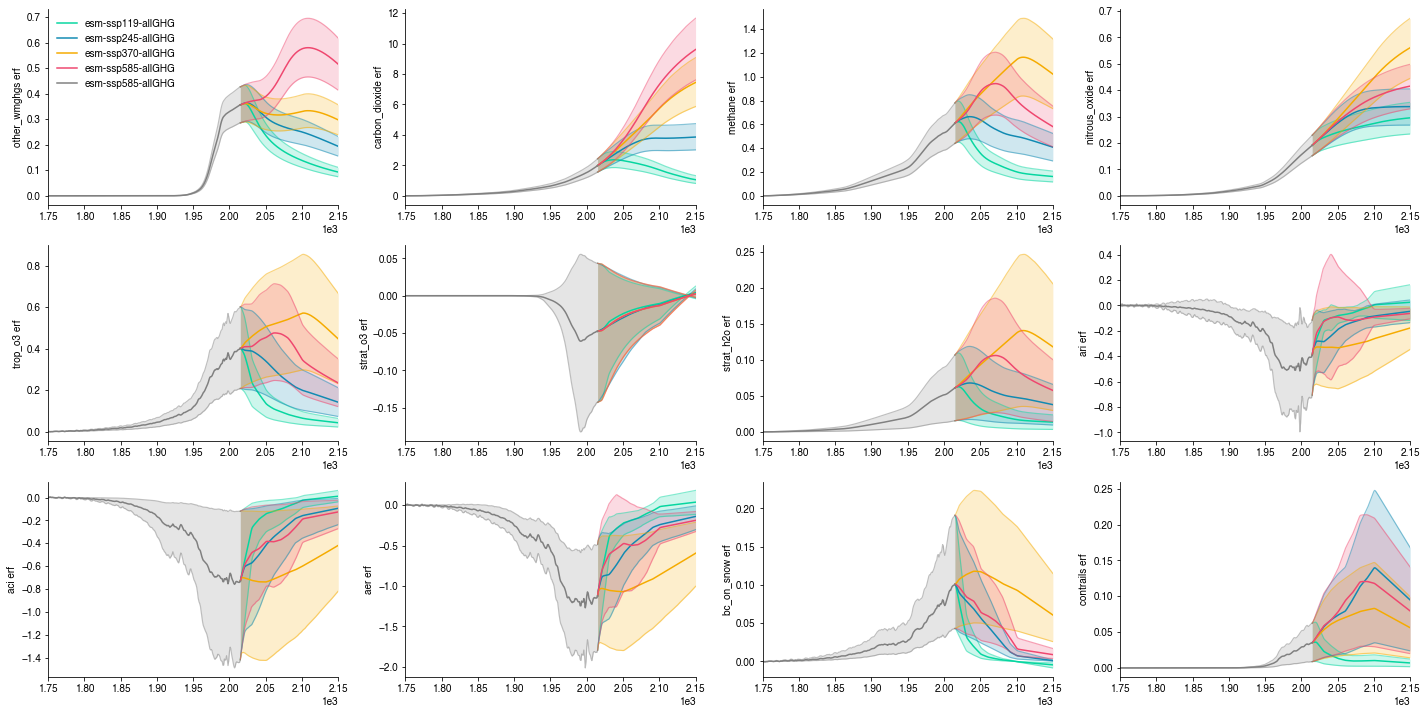

In [8]:
fig,ax=plt.subplots(3,4,figsize=(20,10))
colors= {'esm-ssp245-allGHG':'#118ab2','esm-ssp370-allGHG':'#F5AB00','esm-ssp585-allGHG':'#ef476f','esm-ssp119-allGHG':'#06d6a0','history':'grey'}
for i,forc_cat in enumerate(param_categories.keys()):
    for scenario in ssp_run1['RF'].columns.levels[0]:
        plot_data = ssp_run1['RF'].loc[:,(scenario,slice(None),param_categories[forc_cat])].groupby(level=(0,1),axis=1).sum()
        plot_data.loc[2015:].groupby(level=0,axis=1).mean().plot(ax=ax.flatten()[i],color=colors[scenario],legend=None)
        ax.flatten()[i].fill_between(plot_data.loc[2015:].index,*np.quantile(plot_data.loc[2015:],[0.05,0.95],axis=1),color=colors[scenario],alpha=0.2,lw=0)
        ax.flatten()[i].plot(plot_data.loc[2015:].index,np.quantile(plot_data.loc[2015:],[0.05,0.95],axis=1).T,color=colors[scenario],alpha=0.5,lw=1.2)
        
    plot_data.loc[:2015].groupby(level=0,axis=1).mean().plot(ax=ax.flatten()[i],color=colors['history'],legend=None)
    ax.flatten()[i].fill_between(plot_data.loc[:2015].index,*np.quantile(plot_data.loc[:2015],[0.05,0.95],axis=1),color=colors['history'],alpha=0.2,lw=0)
    ax.flatten()[i].plot(plot_data.loc[:2015].index,np.quantile(plot_data.loc[:2015],[0.05,0.95],axis=1).T,color=colors['history'],alpha=0.5,lw=1.2)
        
    ax.flatten()[i].set_ylabel(forc_cat+' erf')

[a.spines[pos].set_visible(False) for a in ax.flatten() for pos in ['right','top']]
[a.set_xlim(1750,2150) for a in ax.flatten()]
ax.flatten()[0].legend(loc='best')
plt.tight_layout()

# [fig.savefig('/home/leachl/Documents/Simple_models/FaIR_v2-0_paper/Plots/SSP_NROY_ERF_grid.'+x,bbox_inches='tight',dpi=600) for x in ['png','pdf','svg']]

In [9]:
## Import some temperature data
baseline = ['1850','1900']

url = "https://www.metoffice.gov.uk/hadobs/hadcrut4/data/current/time_series/HadCRUT.4.6.0.0.monthly_ns_avg.txt"
req = requests.get(url, headers=header)
data = StringIO(req.text)
HadCRUT4 = pd.read_csv(data,delim_whitespace=True,index_col=0,names=['date','anom','lower_bias','upper_bias','lower_measure','upper_measure','lower_cover','upper_cover','lower_bias_measure','upper_bias_measure','lower_full','upper_full']).apply(pd.to_numeric)
HadCRUT4.index = pd.to_datetime(['-'.join(x.split('/'))+'-01' for x in HadCRUT4.index])
HadCRUT4 = HadCRUT4['anom'].rename('HadCRUT4')

GISS = pd.read_csv("https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.txt",skiprows=7,skipfooter=7,delim_whitespace=True,index_col=0).iloc[:,:12]
GISS = GISS.loc[GISS.index!='Year'].replace('****',np.nan).apply(pd.to_numeric)/100
month_map = dict(zip(GISS.columns,["{:02d}".format(x) for x in np.arange(1,13)]))
GISS = pd.DataFrame(GISS.values.flatten(),index = pd.to_datetime([x+'-'+month_map[y]+'-01' for x in GISS.index for y in GISS.columns]),columns=['anom'])
GISS = GISS['anom'].rename('GISTEMP')

CW_Had4_krig = pd.read_csv("https://www-users.york.ac.uk/~kdc3/papers/coverage2013/had4_krig_v2_0_0.txt",delim_whitespace=True,index_col=0,names=['date','anom','unc_full','unc_cover','unc_ens']).apply(pd.to_numeric)
CW_Had4_krig.index = pd.to_datetime([str(int(x//1))+'-'+"{:02d}".format(int((x % 1)*12)+1)+'-01' for x in CW_Had4_krig.index])
CW_Had4_krig = CW_Had4_krig['anom'].rename('CW')

Berkeley = pd.read_csv("http://berkeleyearth.lbl.gov/auto/Global/Land_and_Ocean_complete.txt",skiprows=76,delim_whitespace=True,usecols=[0,1,2,3],names=['date','month','anom','unc_full'])
Berkeley = Berkeley.iloc[:Berkeley.loc[Berkeley.date=='%'].index.min()].apply(pd.to_numeric)
Berkeley.index = pd.to_datetime(Berkeley.date.astype(str) + Berkeley.month.astype(str),format='%Y%m')
Berkeley = Berkeley['anom'].rename('Berkeley')

parser = 'html.parser'  # or 'lxml' (preferred) or 'html5lib', if installed
resp = urllib.request.urlopen("https://www.ncei.noaa.gov/data/noaa-global-surface-temperature/v5/access/timeseries/")
soup = BeautifulSoup(resp, parser, from_encoding=resp.info().get_param('charset'))
NOAA_fname = [x['href'] for x in soup.find_all('a', href=True) if x['href'].split('.')[1:5]==['mon','land_ocean','90S','90N']][0]
NOAA = pd.read_csv("https://www.ncei.noaa.gov/data/noaa-global-surface-temperature/v5/access/timeseries/"+NOAA_fname,delim_whitespace=True,names=['date','month','anom','unc_full'],usecols=[0,1,2,3]).apply(pd.to_numeric)
NOAA.index = pd.to_datetime(NOAA.date.astype(str) + NOAA.month.astype(str),format='%Y%m')
NOAA = NOAA['anom'].rename('NOAA')

## Combine into a single df

GMST_datasets = pd.concat([HadCRUT4,CW_Had4_krig,GISS,NOAA,Berkeley],axis=1)

## Baseline to 1861:1880 OR to HadCRUT4 20C mean if data begins in 1880 (GISTEMP / NOAA)

GMST_datasets.loc[:,['HadCRUT4','CW','Berkeley']] -= GMST_datasets.loc[baseline[0]:baseline[1],['HadCRUT4','CW','Berkeley']].mean()
GMST_datasets.loc[:,['GISTEMP','NOAA']] -= GMST_datasets.loc['1900':'2000',['GISTEMP','NOAA']].mean() -  GMST_datasets.loc['1900':'2000','HadCRUT4'].mean()

/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 1.05, 'Constrained FaIR ensemble')

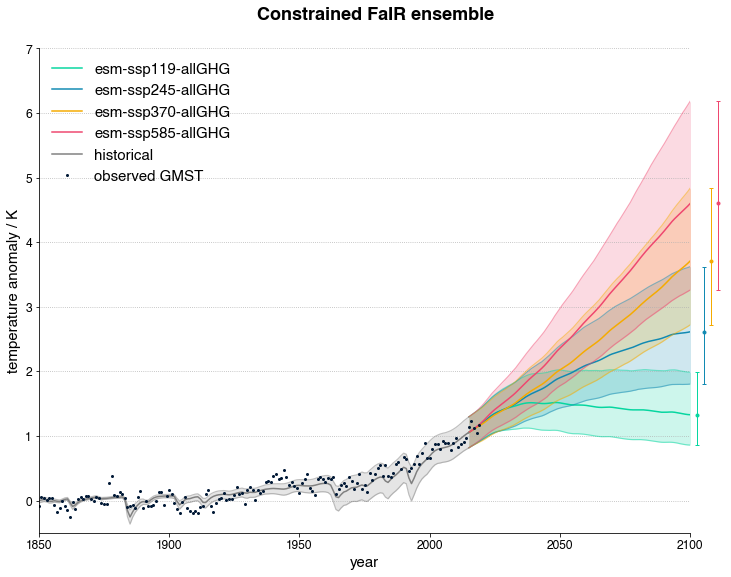

In [10]:
fig = plt.figure(figsize=(10,7.5))
gs = fig.add_gridspec(1, 20,wspace=0)
ax = fig.add_subplot(gs[0,:-1])
colors= {'esm-ssp245-allGHG':'#118ab2','esm-ssp370-allGHG':'#F5AB00','esm-ssp585-allGHG':'#ef476f','esm-ssp119-allGHG':'#06d6a0','history':'grey'}
for scenario in ssp_run1['T'].columns.levels[0]:
    plot_data = ssp_run1['T'].loc[:,(scenario)] - ssp_run1['T'].loc[1850:1900,(scenario)].mean()
    plot_data.loc[2015:].mean(axis=1).plot(ax=ax,color=colors[scenario],label=scenario)
    ax.fill_between(plot_data.loc[2015:].index,*np.quantile(plot_data.loc[2015:],[0.05,0.95],axis=1),color=colors[scenario],alpha=0.2,lw=0)
    ax.plot(plot_data.loc[2015:].index,np.quantile(plot_data.loc[2015:],[0.05,0.95],axis=1).T,color=colors[scenario],alpha=0.5,lw=1.2)
    
plot_data = ssp_run1['T'].loc[:,(scenario)] - ssp_run1['T'].loc[1850:1900,(scenario)].mean()
plot_data.loc[:2015].mean(axis=1).plot(ax=ax,color=colors['history'],label='historical')
ax.fill_between(plot_data.loc[:2015].index,*np.quantile(plot_data.loc[:2015],[0.05,0.95],axis=1),color=colors['history'],alpha=0.2,lw=0)
ax.plot(plot_data.loc[:2015].index,np.quantile(plot_data.loc[:2015],[0.05,0.95],axis=1).T,color=colors['history'],alpha=0.5,lw=1.2)
    
plt.plot(np.arange(1850,2020),GMST_datasets.loc[:'2019'].mean(axis=1).resample('y').mean().values,'.',ms=4,label='observed GMST')

ax1 = fig.add_subplot(gs[0,-1])
for i,scenario in enumerate(ssp_run1['T'].columns.levels[0]):
    plot_data = ssp_run1['T'].loc[2100,(scenario)] - ssp_run1['T'].loc[1850:1900,(scenario)].mean()
    plot_mean = plot_data.mean()
    plot_lower =  plot_mean - np.quantile(plot_data,0.05)
    plot_upper = np.quantile(plot_data,0.95) - plot_mean
    ax1.errorbar(i,plot_mean,np.array([[plot_lower],[plot_upper]]),color=colors[scenario],capsize=2,fmt='.',lw=1)

ax.yaxis.grid(ls=':')
ax.set_ylim(-0.5,7)
ax1.set_ylim(-0.5,7)
ax1.axis('off')
[ax.spines[pos].set_visible(False) for pos in ['right','top']]
ax.set_xlim(1850,2100)
ax1.set_xlim(-1,4)
ax.legend(loc='upper left',fontsize=15)
plt.tight_layout()
ax.set_ylabel('temperature anomaly / K',fontsize=15)
ax.set_xlabel('year',fontsize=15)
ax.tick_params(labelsize=12)
ax.ticklabel_format(style="plain")

fig.suptitle('Constrained FaIR ensemble',fontweight='bold',fontsize=18,y=1.05)

# [fig.savefig('/home/leachl/Documents/Simple_models/FaIR_v2-0_paper/Plots/SSP_NROY_temp.'+x,bbox_inches='tight',dpi=600) for x in ['png','pdf','svg']]

### Saving the ensemble to disk

In [12]:
test_sav = ssp_run1['C'].copy()

In [20]:
test_sav = test_sav.apply(lambda x: x / GIR_to_RCMIP_map.loc[x.name[2],'RCMIP_concs_scaling'] ).T.reset_index()
test_sav=test_sav.set_index('Gas name')

In [21]:
test_sav['Variable']=GIR_to_RCMIP_map.loc[test_sav.index,'RCMIP_concs_key']
test_sav['Unit']=GIR_to_RCMIP_map.loc[test_sav.index,'RCMIP_concs_unit']
test_sav['Model']='unspecified'
test_sav['Climatemodel']='FaIRv2.0.0-alpha-constrained'
test_sav['Region']='World'

In [25]:
test_sav.set_index(['Region','Scenario','Variable','Model','Unit','Climatemodel','Gas cycle set'],inplace=True)
test_sav.index.set_names('member',level=-1,inplace=True)
test_sav.columns = [str(x) for x in test_sav.columns]

In [34]:
test_sav.to_parquet('../GIR_output/RCMIP/test_1.parquet.gzip',compression='gzip')

In [18]:
GIR_to_RCMIP_map

,native_emms_unit,native_concs_unit,RCMIP_emms_key,RCMIP_emms_unit,RCMIP_emms_scaling,RCMIP_concs_key,RCMIP_concs_unit,RCMIP_concs_scaling
c2f6,Mt,ppb,Emissions|F-Gases|PFC|C2F6,kt C2F6/yr,0.001000,Atmospheric Concentrations|F-Gases|PFC|C2F6,ppt,0.001
c3f8,Mt,ppb,Emissions|F-Gases|PFC|C3F8,kt C3F8/yr,0.001000,Atmospheric Concentrations|F-Gases|PFC|C3F8,ppt,0.001
c4f10,Mt,ppb,Emissions|F-Gases|PFC|C4F10,kt C4F10/yr,0.001000,Atmospheric Concentrations|F-Gases|PFC|C4F10,ppt,0.001
c5f12,Mt,ppb,Emissions|F-Gases|PFC|C5F12,kt C5F12/yr,0.001000,Atmospheric Concentrations|F-Gases|PFC|C5F12,ppt,0.001
c6f14,Mt,ppb,Emissions|F-Gases|PFC|C6F14,kt C6F14/yr,0.001000,Atmospheric Concentrations|F-Gases|PFC|C6F14,ppt,0.001
c7f16,Mt,ppb,Emissions|F-Gases|PFC|C7F16,kt C7F16/yr,0.001000,Atmospheric Concentrations|F-Gases|PFC|C7F16,ppt,0.001
c8f18,Mt,ppb,Emissions|F-Gases|PFC|C8F18,kt C8F18/yr,0.001000,Atmospheric Concentrations|F-Gases|PFC|C8F18,ppt,0.001
c_c4f8,Mt,ppb,Emissions|F-Gases|PFC|cC4F8,kt cC4F8/yr,0.001000,Atmospheric Concentrations|F-Gases|PFC|cC4F8,ppt,0.001
carbon_dioxide,GtC,ppm,Emissions|CO2,Mt CO2/yr,0.000273,Atmospheric Concentrations|CO2,ppm,1.000
carbon_tetrachloride,Mt,ppb,Emissions|Montreal Gases|CCl4,kt CCl4/yr,0.001000,Atmospheric Concentrations|Montreal Gases|CCl4,ppt,0.001


In [32]:
magicc_scm

Model  \
Region Scenario Variable                                                          
World  1pctCO2  Atmospheric Concentrations|CH4                      unspecified   
                Atmospheric Concentrations|CO2                      unspecified   
                Atmospheric Concentrations|F-Gases|HFC|HFC125       unspecified   
                Atmospheric Concentrations|F-Gases|HFC|HFC134a      unspecified   
                Atmospheric Concentrations|F-Gases|HFC|HFC143a      unspecified   
...                                                                         ...   
       ssp585   Radiative Forcing|Anthropogenic|Stratospheric O...  unspecified   
                Radiative Forcing|Anthropogenic|Tropospheric Ozone  unspecified   
                Radiative Forcing|Natural|Solar                     unspecified   
                Radiative Forcing|Natural|Volcanic                  unspecified   
                Surface Air Temperature Change                      unspecified   

                                                                       Unit  \
Region Scenario Variable                                                      
World  1pctCO2  Atmospheric Concentrations|CH4                          ppb   
                Atmospheric Concentrations|CO2                          ppm   
                Atmospheric Concentrations|F-Gases|HFC|HFC125           ppt   
                Atmospheric Concentrations|F-Gases|HFC|HFC134a          ppt   
                Atmospheric Concentrations|F-Gases|HFC|HFC143a          ppt   
...                                                                     ...   
       ssp585   Radiative Forcing|Anthropogenic|Stratospheric O...  W / m^2   
                Radiative Forcing|Anthropogenic|Tropospheric Ozone  W / m^2   
                Radiative Forcing|Natural|Solar                     W / m^2   
                Radiative Forcing|Natural|Volcanic                  W / m^2   
                Surface Air Temperature Change                            K   

                                                                                      Climatemodel  \
Region Scenario Variable                                                                             
World  1pctCO2  Atmospheric Concentrations|CH4                      MAGICC7.1.0.beta-rcmip-phase-1   
                Atmospheric Concentrations|CO2                      MAGICC7.1.0.beta-rcmip-phase-1   
                Atmospheric Concentrations|F-Gases|HFC|HFC125       MAGICC7.1.0.beta-rcmip-phase-1   
                Atmospheric Concentrations|F-Gases|HFC|HFC134a      MAGICC7.1.0.beta-rcmip-phase-1   
                Atmospheric Concentrations|F-Gases|HFC|HFC143a      MAGICC7.1.0.beta-rcmip-phase-1   
...                                                                                            ...   
       ssp585   Radiative Forcing|Anthropogenic|Stratospheric O...  MAGICC7.1.0.beta-rcmip-phase-1   
                Radiative Forcing|Anthropogenic|Tropospheric Ozone  MAGICC7.1.0.beta-rcmip-phase-1   
                Radiative Forcing|Natural|Solar                     MAGICC7.1.0.beta-rcmip-phase-1   
                Radiative Forcing|Natural|Volcanic                  MAGICC7.1.0.beta-rcmip-phase-1   
                Surface Air Temperature Change                      MAGICC7.1.0.beta-rcmip-phase-1   

                                                                          1850  \
Region Scenario Variable                                                         
World  1pctCO2  Atmospheric Concentrations|CH4                      808.331570   
                Atmospheric Concentrations|CO2                      282.899000   
                Atmospheric Concentrations|F-Gases|HFC|HFC125         0.000000   
                Atmospheric Concentrations|F-Gases|HFC|HFC134a        0.000000   
                Atmospheric Concentrations|F-Gases|HFC|HFC143a        0.000000   
...                                                              

## Default parameter historical run

In [4]:
## import concentrations:
CMIP6_conc_ftp = ftplib.FTP('data.iac.ethz.ch','anonymous')
CMIP6_conc_ftp.cwd('CMIP6/input4MIPs/UoM/GHGConc/CMIP/yr/atmos/UoM-CMIP-1-1-0/GHGConc/gr3-GMNHSH/v20160701')
CMIP6_ftp_list = [x for x in CMIP6_conc_ftp.nlst() if x[-3:]=='csv']
WMGHG_concs = pd.DataFrame(dict(zip(['_'.join(x.split('_')[3:-8]) for x in CMIP6_ftp_list],[pd.read_csv('ftp://data.iac.ethz.ch/CMIP6/input4MIPs/UoM/GHGConc/CMIP/yr/atmos/UoM-CMIP-1-1-0/GHGConc/gr3-GMNHSH/v20160701/'+x,usecols=[0,1],index_col=0).iloc[:,0] for x in CMIP6_ftp_list])))
WMGHG_concs = WMGHG_concs[[x for x in WMGHG_concs.columns if x[-2:]!='eq']] # remove "equivalent" concentrations

WMGHG_concs['halon1202'] = 0
WMGHG_concs.loc[1765:2014,'halon1202'] = pd.read_csv('http://www.pik-potsdam.de/~mmalte/rcps/data/RCP45_MIDYEAR_CONCENTRATIONS.DAT',skiprows=38,delim_whitespace=True,index_col=0)['HALON1202'].loc[1765:2014].values

NOAA_mole_fractions_2020 = pd.read_csv('https://www.esrl.noaa.gov/gmd/aggi/NOAA_MoleFractions_2020.csv',skiprows=2,index_col=0,skipfooter=5).iloc[1:].replace('nd',np.nan).apply(pd.to_numeric)

scale_factor = (WMGHG_concs.loc[2014,'carbon_dioxide'] / NOAA_mole_fractions_2020.loc[2014:2015,'CO2']).values

CO2_concs = pd.Series(np.append(WMGHG_concs.loc[1750:,'carbon_dioxide'].values.flatten(),NOAA_mole_fractions_2020.loc[2015:,'CO2']*scale_factor),index=np.arange(1750,2020),name='CO2')

/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  # This is added back by InteractiveShellApp.init_path()


In [8]:
default_thermal = pd.DataFrame([[239,4.1],[0.33,0.41]],index=['d','q'],columns=pd.MultiIndex.from_product([['default'],[1,2]]))
default_ssp_run = run_GIR(emissions_in=ssp_emms,forcing_in=ssp_forc,gas_parameters=pd.concat([default_params],axis=1,keys=['default']),thermal_parameters=default_thermal)

Integrating 4 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'halon

100%|██████████| 400/400 [00:00<00:00, 3472.01 timestep/s]


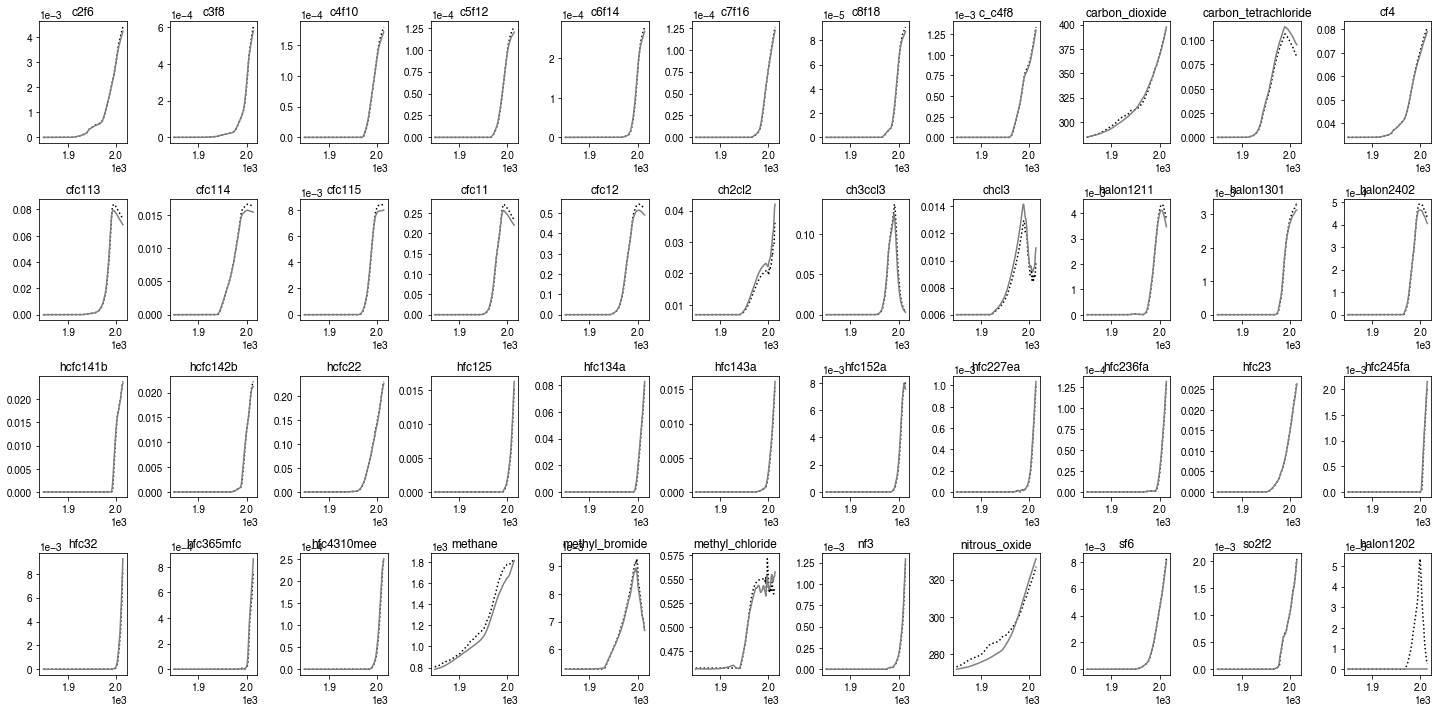

In [9]:
fig,ax = plt.subplots(4,11,figsize=(20,10))

for i,gas in enumerate(WMGHG_concs.columns):
    if gas in ['nitrous_oxide','carbon_dioxide','methane']:
        ax.flatten()[i].plot(WMGHG_concs.loc[1850:,gas],':',c='k')
    else:
        ax.flatten()[i].plot(WMGHG_concs.loc[1850:,gas]/1000,':',c='k')
    ax.flatten()[i].plot(default_ssp_run['C'].loc[1850:2014,('esm-ssp245-allGHG','default',gas)],color='grey')
    ax.flatten()[i].set_title(gas)
    
plt.tight_layout()

<AxesSubplot:xlabel='year'>

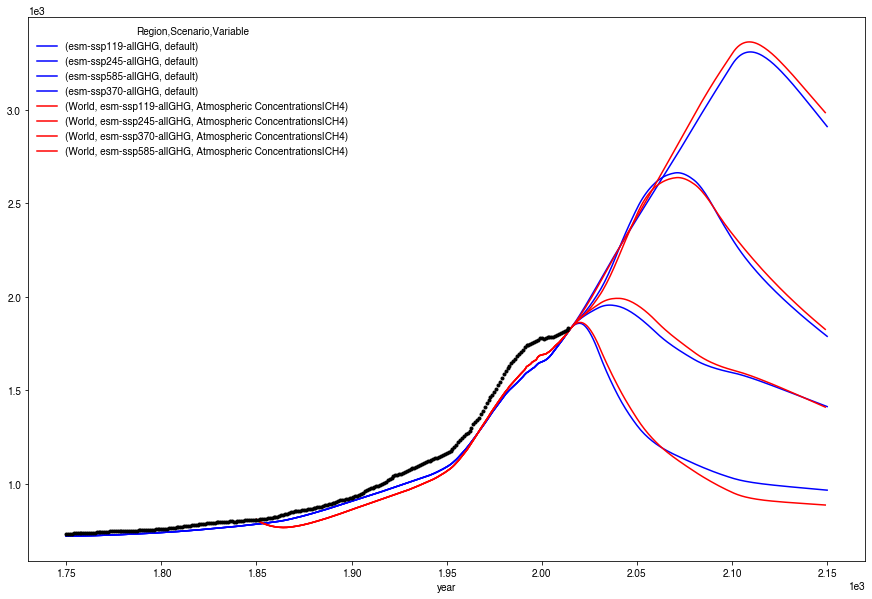

In [10]:
fig,ax = plt.subplots(figsize=(15,10))
(default_ssp_run['C'].xs('methane',axis=1,level=-1)).plot(ax=ax,c='b')
magicc_scm.loc[('World',['esm-ssp119-allGHG','esm-ssp245-allGHG','esm-ssp370-allGHG','esm-ssp585-allGHG'],'Atmospheric Concentrations|CH4'),range(1850,2150)].T.plot(ax=ax,c='r')

WMGHG_concs['methane'].loc[1750:].plot(ax=ax,marker='.',lw=0,c='k')

## Default parameter RCP run:_

In [11]:
## RCMIP SSP emissions:
scenarios = ['rcp'+x for x in ['26','45','60','85']]#['ssp'+x for x in ['119','126','245','370','370-lowNTCF-aerchemmip','370-lowNTCF-gidden','434','460','534-over','585']]
rcp_emms = pd.concat([RCMIP_to_GIR_input_emms(x).dropna(axis=1,how='all').dropna() for x in scenarios],keys=scenarios,axis=1).interpolate()
rcp_emms = rcp_emms.loc[1750:2150] - rcp_emms.loc[1765]
rcp_forc = pd.concat([get_RCMIP_forc(x,drivers=['Radiative Forcing|Natural','Radiative Forcing|Anthropogenic|Albedo Change']) for x in scenarios],keys=scenarios,axis=1).interpolate().loc[1765:2150]

# ## switch in GCP co2 emissions up to start of SSPs
# GCP_historical_emissions=pd.read_csv('https://raw.githubusercontent.com/openclimatedata/global-carbon-budget/master/data/historical-budget.csv',index_col=0,usecols=[0,1,2])
# # set 1750 value to 0
# GCP_historical_emissions.loc[1750,'Fossil-Fuel-Industry'] = 0
# # linearly interpolate between 0 and first land-use-change datapoint
# GCP_historical_emissions.loc[1750:1849,'Land-Use-Change'] = np.linspace(0,0.99,100) * GCP_historical_emissions.loc[1850,'Land-Use-Change']

# for ssp in ssp_emms.columns.levels[0]:
#     sf = GCP_historical_emissions.sum(axis=1).loc[2015] / ssp_emms.loc[2015,(ssp,'carbon_dioxide')]
#     ssp_emms.loc[:2014,(ssp,'carbon_dioxide')] = GCP_historical_emissions.sum(axis=1).loc[1750:2014]
#     ssp_emms.loc[2015:2025,(ssp,'carbon_dioxide')] *= np.linspace(sf,1,11)

In [12]:
rcp_run1 = run_GIR(emissions_in=rcp_emms,forcing_in=rcp_forc,gas_parameters=pd.concat([default_params.reindex([x for x in default_params.columns if x.split('|')[0] in rcp_emms.columns.levels[-1]],axis=1)],axis=1,keys=['default']),thermal_parameters=default_thermal)

Integrating 4 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c6f14', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch3ccl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc227ea', 'hfc23', 'hfc245fa', 'hfc32', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nitrous_oxide', 'sf6', 'halon1202', 'so2', 'nox', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'halon2402|strat_o3', 'hcfc141b|strat_o3', 'hcfc142b|strat_o3', 'hcfc22|strat_o3', 'methyl_bromide|strat_o3', 'methyl_chloride|strat_o3', 'halon1202|strat_o3'] for

100%|██████████| 385/385 [00:00<00:00, 3357.76 timestep/s]


In [1]:
rcp_run1['C'].xs('methane',axis=1,level=-1).plot()

NameError: name 'rcp_run1' is not defined